<a href="https://colab.research.google.com/github/Alx-Lebeau/Cours-EcoElec/blob/main/notebooks/02_Equilibre_Long_Terme_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf Cours-EcoElec
!git clone https://github.com/Alx-Lebeau/Cours-EcoElec.git
%cd Cours-EcoElec/notebooks
!ls


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pulp as pl
import config


Cloning into 'Cours-EcoElec'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 176 (delta 43), reused 33 (delta 33), pack-reused 127 (from 1)
Receiving objects: 100% (176/176), 2.31 MiB | 5.09 MiB/s, done.
Resolving deltas: 100% (73/73), done.
/content/Cours-EcoElec/notebooks
01_Equilibre_Court_Terme_correction.ipynb  config.py
01_Equilibre_Court_Terme_énoncé.ipynb	   Consommation_France_2024.csv
02_Equilibre_Long_Terme.ipynb		   Disponibilites_2024.csv


 # Import des données

 On utilise les mêmes données que pour le TP sur [l'équilibre court terme](https://github.com/Alx-Lebeau/Cours-EcoElec/blob/main/notebooks/01_Equilibre_Court_Terme_correction.ipynb).

In [2]:
# Import des données
df_conso = pd.read_csv("Consommation_France_2024.csv",index_col=0)
df_conso["heure"] = pd.to_datetime(df_conso["heure"])


# Import des données
df_dispo = pd.read_csv("Disponibilites_2024.csv",index_col=0)
df_dispo["heure"] = pd.to_datetime(df_dispo["heure"])

In [3]:
df_dispo.mean()

,0
heure,2024-07-02 00:04:25.573770240
solaire,0.14
eolien,0.25
nucleaire,0.8
hydraulique,1.0
gaz,0.9
imports,1.0


# Méthode des screening curves

Nous allons commencer par un exemple concret d'utilisation de la méthode *screening curves* (cf. cours).

On commence par tracer la **monotone de consommation** :

Text(0.5, 0, "Nombre d'heure")

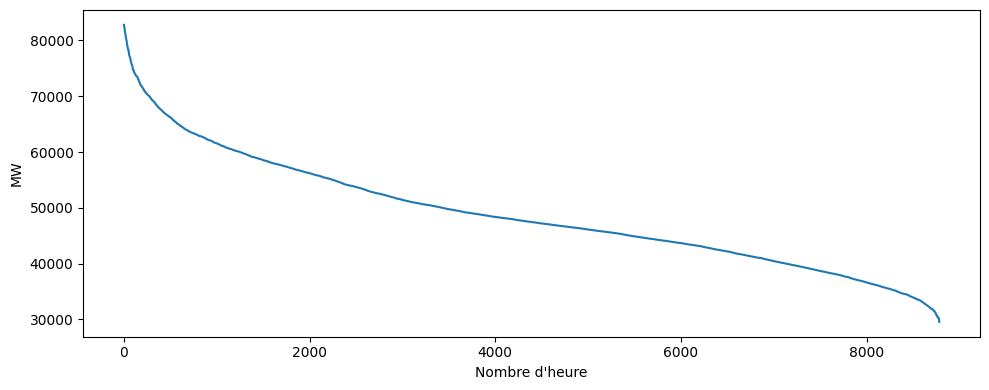

In [4]:
# Visualisation de l'évolution annuelle de la consommation réalisée

fig, ax = plt.subplots(tight_layout=True,figsize =(10,4))

monotone = df_conso["Consommation réalisée (MW)"].sort_values(ascending=False).values

ax.plot(monotone)

ax.set_ylabel("MW")
ax.set_xlabel("Nombre d'heure")


Pour rappel, la méthode **screening curves** s'applique dans un cadre très simplifié, avec uniquement des filières de production conventionnelles, sans prendre en compte les interconnexions ou les stockages.

Pour cet exemple, on utilise deux filières `nucléaire` et `gaz` (à nouveau, données illustratives). Le coût de l'énergie délestée (VOLL) est choisi à 33000 €/MWh.

In [5]:
donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "cout_fixe": 400000.0},
    "gaz": {"cout_variable": 80.0,
            "cout_fixe": 90000}
}

VOLL = 33000 # €/MWh

On trace ensuite les courbes de coût total pour les différentes filières, ainsi que pour le délestage.

NB : ces courbes de coûts total se construisent pour 1 MW *disponible*, il faut donc diviser les coûts par la disponibilité (ici supposée constante) pour avoir la bonne valeur de coût fixe.

(0.0, 700.0)

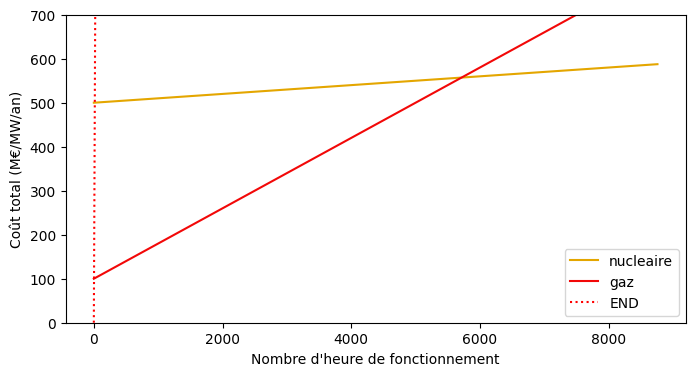

In [6]:
fig, ax = plt.subplots(figsize=(8,4))

t = np.arange(8760)

for i in donnees_filieres :

  dispo_moyenne = df_dispo.mean()[i]

  cost_curve = (donnees_filieres[i]["cout_fixe"] /dispo_moyenne) + donnees_filieres[i]["cout_variable"]*t
  ax.plot(cost_curve / 1000,
          label = i,
          color = config.couleurs[i])

END_curve = VOLL * t

ax.plot(END_curve / 1000,
        label ="END",
        color ="red",
        ls=":")

ax.set_xlabel("Nombre d'heure de fonctionnement")
ax.set_ylabel("Coût total (M€/MW/an)")

ax.legend(loc="best")
ax.set_ylim([0,700])
# ax.set_xlim([0,100]) # à décommenter pour faire un zoom

Les durées d'équilibres entre deux filières $1$ et $2$ sont déterminées par :

$D_{1/2} = \frac{CF_1/\alpha_1-CF_2/\alpha_2}{CV_2-CV_1}$

On obtient donc ici une durée d'équilibre de 5714 heures entre gaz et nucléaire (= le nucléaire est compétitif devant le gaz s'il produit plus de 2143 heures) et de 3 heures entre le gaz et la délestage.

In [7]:
capa_nuc = monotone[5714]
capa_total = monotone[3]
capa_gaz = capa_total - capa_nuc
profondeur_delestage = monotone[0] - capa_total

print(capa_nuc, capa_gaz, capa_total,profondeur_delestage)

44383.0 38099.0 82482.0 318.0


On peut donc en conclure, sur cet exemple simple, que le dimensionnement optimal consiste à installer 44,4 GW de nucléaire et 38 GW de gaz. La profondeur du délestage est de 318 MW.

# Formulation comme un problème d'optimisation : cas simple (le même que pour les screening curves)

## Ecriture du problème mathématique


### Notations

#### Ensembles

- $\mathcal{F}$ : ensemble des filières de production  
- $\mathcal{T}$ : ensemble des pas de temps  

#### Paramètres

- $\text{CV}_i$ : coût variable de la filière $i$ (€/MWh)  
- $\text{CF}_i$ : coût fixe annuel d’investissement de la filière $i$ (€/MW/an)  
- $d_t$ : demande au pas de temps $t$ (MW)  
- $\text{VOLL}$ : coût de l’énergie non distribuée (€/MWh)  
- $\alpha_{i,t}$ : disponibilité de la filière $i$ au pas de temps $t$ (entre 0 et 1)

#### Variables de décision

- $p_{i,t}$ : production de la filière $i$ au pas de temps $t$ (MW)  
- $K_i$ : capacité installée de la filière $i$ (MW)  🆕
- $\text{END}_t$ : énergie non distribuée au pas de temps $t$ (MW)


## Problème d'optimisation

### Fonction objectif

Le modèle minimise le **coût total du système**, composé :
- des coûts variables de production,
- du coût de l'énergie non distribuée,
- des coûts fixes d'investissement dans les capacités 🆕.

$$
\min_{p_{i,t}, \, K_i, \, \text{END}_t} \;
\sum_{t \in \mathcal{T}} \sum_{i \in \mathcal{F}} \text{CV}_i \cdot p_{i,t}
\;+\;
\sum_{t \in \mathcal{T}} \text{VOLL} \cdot \text{END}_t
\;+\;
\sum_{i \in \mathcal{F}} \text{CF}_i \cdot K_i
$$

### Contraintes

#### Équilibre offre = demande

À chaque pas de temps, la production totale (complétée si besoin par de l’END) doit couvrir la demande :

$$
\forall t \in \mathcal{T}, \qquad
\sum_{i \in \mathcal{F}} p_{i,t} + \text{END}_t = d_t
$$


#### Contrainte de capacité (avec disponibilité)

La production horaire est limitée par la capacité installée et la disponibilité de la filière :

$$
\forall i \in \mathcal{F}, \; \forall t \in \mathcal{T}, \qquad
p_{i,t} \le \alpha_{i,t} \cdot K_i
$$

#### Positivité des variables de décision

$$
\forall i \in \mathcal{F}, \; \forall t \in \mathcal{T}, \qquad
p_{i,t} \ge 0
$$

$$
\forall i \in \mathcal{F}, \qquad
K_i \ge 0 🆕
$$

$$
\forall t \in \mathcal{T}, \qquad
\text{END}_t \ge 0
$$



## Implémentation

In [8]:
donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "cout_fixe": 400000.0},
    "gaz": {"cout_variable": 80.0,
            "cout_fixe": 90000}
}

In [9]:
demande = df_conso["Consommation réalisée (MW)"].values

VOLL = 33000.0  # €/MWh

# ---- Ensembles ----
filieres = list(donnees_filieres.keys())
T = range(len(demande))

# ---- Modèle ----
modele = pl.LpProblem("Dispatch_Electrique_Court_Terme", pl.LpMinimize)


# ---- Variables de décision ----
# prod[i, t] = production de la filière i au temps t (MW)
prod = pl.LpVariable.dicts("prod", (filieres, T), lowBound=0)

# capacités
capa = pl.LpVariable.dicts("capa",(filieres),lowBound=0)


# END[t] = énergie non distribuée au temps t (MW)
END = pl.LpVariable.dicts("END", T, lowBound=0)

# ---- Objectif : minimiser le coût total ----

# 1) coût des filières de production
cout_production = pl.lpSum(
    prod[i][t] * donnees_filieres[i]["cout_variable"]
    for i in filieres
    for t in T
)


# 2) coût de l'énergie non distribuée
cout_END = pl.lpSum(
    END[t] * VOLL
    for t in T
)

# 3) coût d'investissement

cout_invest = pl.lpSum(
    capa[i] * donnees_filieres[i]["cout_fixe"]
    for i in filieres
)

# Objectif total = production + END + cout d'investissement
modele += cout_production + cout_END + cout_invest

# contrainte EOD

for t in T:
    modele += (
        pl.lpSum(prod[i][t] for i in filieres) + END[t] == demande[t],
        f"Equilibre_t{t}"
    )

# contrainte de capacité


for i in filieres:
    for t in T:
        modele += (
            prod[i][t] <= capa[i] * df_dispo.loc[t][i],
            f"Capacite_{i}_t{t}"
        )


# ---- Résolution ----
modele.solve(pl.PULP_CBC_CMD(msg=False))

print("Statut :", pl.LpStatus[modele.status])
print(f"Coût total (Md€/an) : {pl.value(modele.objective)/1e9:.2f}")
print(f"\t dont coût de production (Md€/an) : {pl.value(cout_production)/1e9:.2f}")
print(f"\t dont coût de l'investissement (Md€/an) : {pl.value(cout_invest)/1e9:.2f}")
print(f"\t dont coût de l'END (Md€/an) : {pl.value(cout_END)/1e9:.2f}")



df_resultats_horaires = pd.DataFrame({
    "demande": demande,
    "END": [END[t].value() for t in T],
    "prix_marginal": [
        modele.constraints[f"Equilibre_t{t}"].pi for t in T
    ],
    **{
        f"prod_{i}": [prod[i][t].value() for t in T]
        for i in filieres
    }
})


df_annuel = pd.DataFrame({
    "filiere": filieres,
    "capa_opt_MW": [capa[i].value() for i in filieres],
    "capa_dispo_MW": [capa[i].value() * df_dispo.mean()[i] for i in filieres],
    "cout_fixe_EUR_par_MW": [donnees_filieres[i]["cout_fixe"] for i in filieres],
}).set_index("filiere")

print(f"Prix marginal moyen (moyenne arithmétique) : {df_resultats_horaires['prix_marginal'].mean():.2f} €/MWh")

# calcul des rentes inframarginales :


# Rentes inframarginales (EUR) sur l'horizon + par MW installé (EUR/MW)
df_annuel["rente_inframarginale_EUR"] = {
    i: ((df_resultats_horaires["prix_marginal"] - donnees_filieres[i]["cout_variable"])
        * df_resultats_horaires[f"prod_{i}"]).sum()
    for i in filieres
}

df_annuel["rente_inframarginale_EUR_par_MW"] = (
    df_annuel["rente_inframarginale_EUR"] / df_annuel["capa_opt_MW"]
)



Statut : Optimal
Coût total (Md€/an) : 34.21
	 dont coût de production (Md€/an) : 8.20
	 dont coût de l'investissement (Md€/an) : 26.00
	 dont coût de l'END (Md€/an) : 0.01
Prix marginal moyen (moyenne arithmétique) : 66.92 €/MWh


In [10]:
df_annuel

,capa_opt_MW,capa_dispo_MW,cout_fixe_EUR_par_MW,rente_inframarginale_EUR,rente_inframarginale_EUR_par_MW
filiere,,,,,
nucleaire,55478.750,44383.0000,400000.0,2.219150e+10,400000.000000
gaz,42332.222,38098.9998,90000.0,3.809900e+09,90000.000472


On constate que l'on retrouve bien les mêmes capacités disponibles qu'avec les méthodes des screening curves.

On observe également que les rentes inframarginales permettent exactement de couvrir les coûts fixes.

# En ajoutant les énergies renouvelables

Contrairement à la méthode des *screening curves*, la résolution via un problème d'optimisation permet d'ajouter des filières de production dont la disponibilité varie heure par heure comme les renouvelables.

## sans contraintes sur le développement des capacités

In [11]:
donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "cout_fixe": 400000.0},
    "gaz": {"cout_variable": 80.0,
            "cout_fixe": 90000},
    "solaire": {"cout_variable": 0.0,
                 "cout_fixe":78000},
    "eolien": {"cout_variable": 0.0,
                 "cout_fixe":100000}
}

In [12]:
demande = df_conso["Consommation réalisée (MW)"].values

VOLL = 33000.0  # €/MWh

# ---- Ensembles ----
filieres = list(donnees_filieres.keys())
T = range(len(demande))

# ---- Modèle ----
modele = pl.LpProblem("Dispatch_Electrique_Court_Terme", pl.LpMinimize)


# ---- Variables de décision ----
# prod[i, t] = production de la filière i au temps t (MW)
prod = pl.LpVariable.dicts("prod", (filieres, T), lowBound=0)

# capacités
capa = pl.LpVariable.dicts("capa",(filieres),lowBound=0)


# END[t] = énergie non distribuée au temps t (MW)
END = pl.LpVariable.dicts("END", T, lowBound=0)

# ---- Objectif : minimiser le coût total ----

# 1) coût des filières de production
cout_production = pl.lpSum(
    prod[i][t] * donnees_filieres[i]["cout_variable"]
    for i in filieres
    for t in T
)


# 2) coût de l'énergie non distribuée
cout_END = pl.lpSum(
    END[t] * VOLL
    for t in T
)

# 3) coût d'investissement

cout_invest = pl.lpSum(
    capa[i] * donnees_filieres[i]["cout_fixe"]
    for i in filieres
)

# Objectif total = production + END + cout d'investissement
modele += cout_production + cout_END + cout_invest

# contrainte EOD

for t in T:
    modele += (
        pl.lpSum(prod[i][t] for i in filieres) + END[t] == demande[t],
        f"Equilibre_t{t}"
    )

# contrainte de capacité


for i in filieres:
    for t in T:
        modele += (
            prod[i][t] <= capa[i] * df_dispo.loc[t][i],
            f"Capacite_{i}_t{t}"
        )


# ---- Résolution ----
modele.solve(pl.PULP_CBC_CMD(msg=False))

print("Statut :", pl.LpStatus[modele.status])
print(f"Coût total (Md€/an) : {pl.value(modele.objective)/1e9:.2f}")
print(f"\t dont coût de production (Md€/an) : {pl.value(cout_production)/1e9:.2f}")
print(f"\t dont coût de l'investissement (Md€/an) : {pl.value(cout_invest)/1e9:.2f}")
print(f"\t dont coût de l'END (Md€/an) : {pl.value(cout_END)/1e9:.2f}")



df_resultats_horaires = pd.DataFrame({
    "demande": demande,
    "END": [END[t].value() for t in T],
    "prix_marginal": [
        modele.constraints[f"Equilibre_t{t}"].pi for t in T
    ],
    **{
        f"prod_{i}": [prod[i][t].value() for t in T]
        for i in filieres
    }
})


df_annuel = pd.DataFrame({
    "filiere": filieres,
    "capa_opt_MW": [capa[i].value() for i in filieres],
    "capa_dispo_MW": [capa[i].value() * df_dispo.mean()[i] for i in filieres],
    "cout_fixe_EUR_par_MW": [donnees_filieres[i]["cout_fixe"] for i in filieres],
}).set_index("filiere")

print(f"Prix marginal moyen (moyenne arithmétique) : {df_resultats_horaires['prix_marginal'].mean():.2f} €/MWh")

# calcul des rentes inframarginales :


# Rentes inframarginales (EUR) sur l'horizon + par MW installé (EUR/MW)
df_annuel["rente_inframarginale_EUR"] = {
    i: ((df_resultats_horaires["prix_marginal"] - donnees_filieres[i]["cout_variable"])
        * df_resultats_horaires[f"prod_{i}"]).sum()
    for i in filieres
}

df_annuel["rente_inframarginale_EUR_par_MW"] = (
    df_annuel["rente_inframarginale_EUR"] / df_annuel["capa_opt_MW"]
)



Statut : Optimal
Coût total (Md€/an) : 32.95
	 dont coût de production (Md€/an) : 7.33
	 dont coût de l'investissement (Md€/an) : 25.60
	 dont coût de l'END (Md€/an) : 0.02
Prix marginal moyen (moyenne arithmétique) : 66.85 €/MWh


In [13]:
df_annuel

,capa_opt_MW,capa_dispo_MW,cout_fixe_EUR_par_MW,rente_inframarginale_EUR,rente_inframarginale_EUR_par_MW
filiere,,,,,
nucleaire,35841.9430,28673.554400,400000.0,1.433678e+10,400000.008370
gaz,51624.4980,46462.048200,90000.0,4.646205e+09,89999.999613
solaire,9396.1107,1315.455498,78000.0,7.328966e+08,78000.000229
eolien,58882.6990,14720.674750,100000.0,5.888270e+09,100000.000805


La solution optimale inclut maintenant les deux filières renouvelables : 9,4 GW de solaire et 58,9 GW d'éolien. Dans le même temps, la capacité optimale de nucléaire a baissé, tandis que celle de gaz a augmenté.

Du point de vue du coût total, la possibilité d'investir dans de nouvelles filières permet de baisser le coût du système par rapport au cas précédent, de 34,21 Md€/an à 32,95 Md€/an (- 3,7 %).

Le prix moyen a baissé dans une plus faible mesure : de 66,92 €/MWh à 66,85 €/MWh (-0,1 %).

Le résultat sur l'égalité des coûts fixes pour toutes les filières est bien vérifié (aux erreurs numérique près), y compris pour les renouveblables.



## Avec contraintes de gisements

On constate que le solveur a sélectionné de grandes quantités de certaines filières. En pratique, les différentes filières ont des potentiels de développement limités (des *gisements*) que l'on peut vouloir représenter. Ils traduisent la disponibilité des terrains, l'acceptabilité des projets ou des contraintes industrielles sur les volumes de développement atteignables pour un horizon de temps donné.

### Paramètre supplémentaire

- $\overline{K}_i$ : potentiel maximal installable (gisement) de la filière $i$ (MW)

### Contrainte de gisement maximal

La capacité installée de chaque filière est bornée par son potentiel maximal :

$$
\forall i \in \mathcal{F}, \qquad
K_i \le \overline{K}_i
$$


In [14]:
donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "cout_fixe": 400000.0,
                  "capa_max":50000},
    "gaz": {"cout_variable": 80.0,
            "cout_fixe": 90000,
            "capa_max":40000},
    "solaire": {"cout_variable": 0.0,
                 "cout_fixe":78000,
                  "capa_max":30000},
    "eolien": {"cout_variable": 0.0,
                 "cout_fixe":100000,
                  "capa_max":20000}
}

In [15]:
demande = df_conso["Consommation réalisée (MW)"].values

VOLL = 33000.0  # €/MWh

# ---- Ensembles ----
filieres = list(donnees_filieres.keys())
T = range(len(demande))

# ---- Modèle ----
modele = pl.LpProblem("Dispatch_Electrique_Court_Terme", pl.LpMinimize)


# ---- Variables de décision ----
# prod[i, t] = production de la filière i au temps t (MW)
prod = pl.LpVariable.dicts("prod", (filieres, T), lowBound=0)

# capacités
capa = pl.LpVariable.dicts("capa",(filieres),lowBound=0)


# END[t] = énergie non distribuée au temps t (MW)
END = pl.LpVariable.dicts("END", T, lowBound=0)

# ---- Objectif : minimiser le coût total ----

# 1) coût des filières de production
cout_production = pl.lpSum(
    prod[i][t] * donnees_filieres[i]["cout_variable"]
    for i in filieres
    for t in T
)


# 2) coût de l'énergie non distribuée
cout_END = pl.lpSum(
    END[t] * VOLL
    for t in T
)

# 3) coût d'investissement

cout_invest = pl.lpSum(
    capa[i] * donnees_filieres[i]["cout_fixe"]
    for i in filieres
)

# Objectif total = production + END
modele += cout_production + cout_END + cout_invest

# contrainte EOD

for t in T:
    modele += (
        pl.lpSum(prod[i][t] for i in filieres) + END[t] == demande[t],
        f"Equilibre_t{t}"
    )

# contrainte Pmax

for i in filieres:
    for t in T:
        modele += (
            prod[i][t] <= capa[i] * df_dispo.loc[t][i],
            f"Capacite_{i}_t{t}"
        )

# contrainte gisement

for i in filieres :
  if donnees_filieres[i]["capa_max"] != np.inf :
    modele += (
        capa[i] <= donnees_filieres[i]["capa_max"],
        f"capa_max_{i}"
    )

# ---- Résolution ----
modele.solve(pl.PULP_CBC_CMD(msg=False))

print("Statut :", pl.LpStatus[modele.status])
print(f"Coût total (Md€/an) : {pl.value(modele.objective)/1e9:.2f}")
print(f"\t dont coût de production (Md€/an) : {pl.value(cout_production)/1e9:.2f}")
print(f"\t dont coût de l'investissement (Md€/an) : {pl.value(cout_invest)/1e9:.2f}")
print(f"\t dont coût de l'END (Md€/an) : {pl.value(cout_END)/1e9:.2f}")



df_resultats_horaires = pd.DataFrame({
    "demande": demande,
    "END": [END[t].value() for t in T],
    "prix_marginal": [
        modele.constraints[f"Equilibre_t{t}"].pi for t in T
    ],
    **{
        f"prod_{i}": [prod[i][t].value() for t in T]
        for i in filieres
    }
})


df_annuel = pd.DataFrame({
    "filiere": filieres,
    "capa_opt_MW": [capa[i].value() for i in filieres],
    "capa_dispo_MW": [capa[i].value() * df_dispo.mean()[i] for i in filieres],
    "cout_fixe_EUR_par_MW": [donnees_filieres[i]["cout_fixe"] for i in filieres],
}).set_index("filiere")

print(f"Prix marginal moyen (moyenne arithmétique) : {df_resultats_horaires['prix_marginal'].mean():.2f} €/MWh")

# calcul des rentes inframarginales :


# Rentes inframarginales (EUR) sur l'horizon + par MW installé (EUR/MW)
df_annuel["rente_inframarginale_EUR"] = {
    i: ((df_resultats_horaires["prix_marginal"] - donnees_filieres[i]["cout_variable"])
        * df_resultats_horaires[f"prod_{i}"]).sum()
    for i in filieres
}

df_annuel["rente_inframarginale_EUR_par_MW"] = (
    df_annuel["rente_inframarginale_EUR"] / df_annuel["capa_opt_MW"]
)



Statut : Optimal
Coût total (Md€/an) : 34.73
	 dont coût de production (Md€/an) : 6.62
	 dont coût de l'investissement (Md€/an) : 26.58
	 dont coût de l'END (Md€/an) : 1.53
Prix marginal moyen (moyenne arithmétique) : 125.29 €/MWh


In [16]:
df_annuel

,capa_opt_MW,capa_dispo_MW,cout_fixe_EUR_par_MW,rente_inframarginale_EUR,rente_inframarginale_EUR_par_MW
filiere,,,,,
nucleaire,50000.000,40000.00000,400000.0,4.050933e+10,810186.655846
gaz,40000.000,36000.00000,90000.0,2.488752e+10,622188.000000
solaire,12544.899,1756.28586,78000.0,9.785021e+08,77999.999732
eolien,20000.000,5000.00000,100000.0,3.810857e+09,190542.833876


On constate ici que :
*   le coût global a réaugmenté significativement (le problème est plus contraint)
*   le prix moyen a également augmenté
*   les filières qui ont atteint leur limite de gisement ont des rentes inframarginales supérieures à leurs coûts fixes : il s'agit de *rentes de raretés*.





## Avec imposition de niveaux de développement

Il arrive également que l'on veuille imposer un niveau de capacité pour certaines capacités, par exemple pour traduire des engagements pris ou des cibles pour certaines filières, ou pour réaliser des tests de sensibilité.

### Paramètre supplémentaire

- $\underline{K}_i$ : niveau de capacité imposé pour la filière $i$ (MW)


### Contrainte de capacité imposée

La capacité installée de certaines filières peut être fixée imposé :

$$
\forall i \in \mathcal{F}, \qquad
K_i = \underline{K}_i
$$


In [17]:
donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "cout_fixe": 400000.0,
                  "imposition_capacite":np.nan},
    "gaz": {"cout_variable": 80.0,
            "cout_fixe": 90000,
            "imposition_capacite":np.nan},
    "solaire": {"cout_variable": 0.0,
                 "cout_fixe":78000,
                  "imposition_capacite":20000},
    "eolien": {"cout_variable": 0.0,
                 "cout_fixe":100000,
                  "imposition_capacite":np.nan}
}

In [18]:
demande = df_conso["Consommation réalisée (MW)"].values

VOLL = 33000.0  # €/MWh

# ---- Ensembles ----
filieres = list(donnees_filieres.keys())
T = range(len(demande))

# ---- Modèle ----
modele = pl.LpProblem("Dispatch_Electrique_Court_Terme", pl.LpMinimize)


# ---- Variables de décision ----
# prod[i, t] = production de la filière i au temps t (MW)
prod = pl.LpVariable.dicts("prod", (filieres, T), lowBound=0)

# capacités
capa = pl.LpVariable.dicts("capa",(filieres),lowBound=0)


# END[t] = énergie non distribuée au temps t (MW)
END = pl.LpVariable.dicts("END", T, lowBound=0)

# ---- Objectif : minimiser le coût total ----

# 1) coût des filières de production
cout_production = pl.lpSum(
    prod[i][t] * donnees_filieres[i]["cout_variable"]
    for i in filieres
    for t in T
)


# 2) coût de l'énergie non distribuée
cout_END = pl.lpSum(
    END[t] * VOLL
    for t in T
)

# 3) coût d'investissement

cout_invest = pl.lpSum(
    capa[i] * donnees_filieres[i]["cout_fixe"]
    for i in filieres
)

# Objectif total = production + END
modele += cout_production + cout_END + cout_invest

# contrainte EOD

for t in T:
    modele += (
        pl.lpSum(prod[i][t] for i in filieres) + END[t] == demande[t],
        f"Equilibre_t{t}"
    )

# contrainte Pmax

for i in filieres:
    for t in T:
        modele += (
            prod[i][t] <= capa[i] * df_dispo.loc[t][i],
            f"Capacite_{i}_t{t}"
        )

# imposition capacité

for i in filieres :
  if not pd.isna(donnees_filieres[i]["imposition_capacite"]) :
    modele += (
        capa[i] == donnees_filieres[i]["imposition_capacite"],
        f"imposition_capacite_{i}"
    )

# ---- Résolution ----
modele.solve(pl.PULP_CBC_CMD(msg=False))

print("Statut :", pl.LpStatus[modele.status])
print(f"Coût total (Md€/an) : {pl.value(modele.objective)/1e9:.2f}")
print(f"\t dont coût de production (Md€/an) : {pl.value(cout_production)/1e9:.2f}")
print(f"\t dont coût de l'investissement (Md€/an) : {pl.value(cout_invest)/1e9:.2f}")
print(f"\t dont coût de l'END (Md€/an) : {pl.value(cout_END)/1e9:.2f}")



df_resultats_horaires = pd.DataFrame({
    "demande": demande,
    "END": [END[t].value() for t in T],
    "prix_marginal": [
        modele.constraints[f"Equilibre_t{t}"].pi for t in T
    ],
    **{
        f"prod_{i}": [prod[i][t].value() for t in T]
        for i in filieres
    }
})


df_annuel = pd.DataFrame({
    "filiere": filieres,
    "capa_opt_MW": [capa[i].value() for i in filieres],
    "capa_dispo_MW": [capa[i].value() * df_dispo.mean()[i] for i in filieres],
    "cout_fixe_EUR_par_MW": [donnees_filieres[i]["cout_fixe"] for i in filieres],
}).set_index("filiere")

print(f"Prix marginal moyen (moyenne arithmétique) : {df_resultats_horaires['prix_marginal'].mean():.2f} €/MWh")

# calcul des rentes inframarginales :


# Rentes inframarginales (EUR) sur l'horizon + par MW installé (EUR/MW)
df_annuel["rente_inframarginale_EUR"] = {
    i: ((df_resultats_horaires["prix_marginal"] - donnees_filieres[i]["cout_variable"])
        * df_resultats_horaires[f"prod_{i}"]).sum()
    for i in filieres
}

df_annuel["rente_inframarginale_EUR_par_MW"] = (
    df_annuel["rente_inframarginale_EUR"] / df_annuel["capa_opt_MW"]
)



Statut : Optimal
Coût total (Md€/an) : 33.00
	 dont coût de production (Md€/an) : 7.23
	 dont coût de l'investissement (Md€/an) : 25.76
	 dont coût de l'END (Md€/an) : 0.01
Prix marginal moyen (moyenne arithmétique) : 66.80 €/MWh


In [19]:
df_annuel

,capa_opt_MW,capa_dispo_MW,cout_fixe_EUR_par_MW,rente_inframarginale_EUR,rente_inframarginale_EUR_par_MW
filiere,,,,,
nucleaire,32959.079,26367.26320,400000.0,1.318363e+10,400000.012216
gaz,53377.105,48039.39450,90000.0,4.803940e+09,90000.001027
solaire,20000.000,2800.00000,78000.0,1.354684e+09,67734.183226
eolien,62162.771,15540.69275,100000.0,6.216277e+09,100000.000114


On constate ici que le coût augmente, mais que le prix moyen baisse. De plus, on constate que la filière dont on impose le niveau au-dessus de ce qui aurait été optimal ne vérifie pas l'égalité entre coûts fixes et rentes infra-marginales.

# Ajout d'un prix du CO2

## Paramètres supplémentaires

- $\text{FE}_i$ : facteur d’émission de la filière $i$ (tCO$_2$/MWh)  
- $p^{\text{CO}_2}$ : prix du CO$_2$ (€/tCO$_2$)


## Modification de la fonction objectif (prix du CO$_2$)

🆕 Le coût variable de production inclut désormais le coût des émissions de CO$_2$.



$$
\min_{p_{i,t}, \, K_i, \, \text{END}_t} \;
\sum_{t \in \mathcal{T}} \sum_{i \in \mathcal{F}}
\left(
\text{CV}_i
\;+\;
\underbrace{\text{FE}_i \cdot p^{\text{CO}_2}}_{\text{coût CO$_2$}}
\right)
\cdot p_{i,t}
\;+\;
\sum_{t \in \mathcal{T}} \text{VOLL} \cdot \text{END}_t
\;+\;
\sum_{i \in \mathcal{F}} \text{CF}_i \cdot K_i
$$



In [20]:
donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "cout_fixe": 400000.0,
                  "capa_max":50000,
                  "facteur_emission":0},
    "gaz": {"cout_variable": 80.0,
            "cout_fixe": 90000,
            "capa_max":np.inf,
            "facteur_emission":0.4},
    "solaire": {"cout_variable": 0.0,
                 "cout_fixe":78000,
                  "capa_max":np.inf,
                  "facteur_emission":0},
    "eolien": {"cout_variable": 0.0,
                 "cout_fixe":100000,
                  "capa_max":np.inf,
                  "facteur_emission":0}
}

In [21]:
demande = df_conso["Consommation réalisée (MW)"].values

VOLL = 33000.0  # €/MWh

prix_CO2 = 300

# ---- Ensembles ----
filieres = list(donnees_filieres.keys())
T = range(len(demande))

# ---- Modèle ----
modele = pl.LpProblem("Dispatch_Electrique_Court_Terme", pl.LpMinimize)


# ---- Variables de décision ----
# prod[i, t] = production de la filière i au temps t (MW)
prod = pl.LpVariable.dicts("prod", (filieres, T), lowBound=0)

# capacités
capa = pl.LpVariable.dicts("capa",(filieres),lowBound=0)


# END[t] = énergie non distribuée au temps t (MW)
END = pl.LpVariable.dicts("END", T, lowBound=0)

# ---- Objectif : minimiser le coût total ----

# 1) coût des filières de production
cout_production = pl.lpSum(
    prod[i][t] * (donnees_filieres[i]["cout_variable"] + donnees_filieres[i]["facteur_emission"] * prix_CO2)
    for i in filieres
    for t in T
)


# 2) coût de l'énergie non distribuée
cout_END = pl.lpSum(
    END[t] * VOLL
    for t in T
)

# 3) coût d'investissement

cout_invest = pl.lpSum(
    capa[i] * donnees_filieres[i]["cout_fixe"]
    for i in filieres
)

# Objectif total = production + END
modele += cout_production + cout_END + cout_invest

# contrainte EOD

for t in T:
    modele += (
        pl.lpSum(prod[i][t] for i in filieres) + END[t] == demande[t],
        f"Equilibre_t{t}"
    )

# contrainte Pmax

for i in filieres:
    for t in T:
        modele += (
            prod[i][t] <= capa[i] * df_dispo.loc[t][i],
            f"Capacite_{i}_t{t}"
        )

# contrainte gisement

for i in filieres :
  if donnees_filieres[i]["capa_max"] != np.inf :
    modele += (
        capa[i] <= donnees_filieres[i]["capa_max"],
        f"capa_max_{i}"
    )


# ---- Résolution ----
modele.solve(pl.PULP_CBC_CMD(msg=False))

print("Statut :", pl.LpStatus[modele.status])
print(f"Coût total (Md€/an) : {pl.value(modele.objective)/1e9:.2f}")
print(f"\t dont coût de production (Md€/an) : {pl.value(cout_production)/1e9:.2f}")
print(f"\t dont coût de l'investissement (Md€/an) : {pl.value(cout_invest)/1e9:.2f}")
print(f"\t dont coût de l'END (Md€/an) : {pl.value(cout_END)/1e9:.2f}")



df_resultats_horaires = pd.DataFrame({
    "demande": demande,
    "END": [END[t].value() for t in T],
    "prix_marginal": [
        modele.constraints[f"Equilibre_t{t}"].pi for t in T
    ],
    **{
        f"prod_{i}": [prod[i][t].value() for t in T]
        for i in filieres
    }
})


df_annuel = pd.DataFrame({
    "filiere": filieres,
    "capa_opt_MW": [capa[i].value() for i in filieres],
    "capa_dispo_MW": [capa[i].value() * df_dispo.mean()[i] for i in filieres],
    "cout_fixe_EUR_par_MW": [donnees_filieres[i]["cout_fixe"] for i in filieres],
}).set_index("filiere")

print(f"Prix marginal moyen (moyenne arithmétique) : {df_resultats_horaires['prix_marginal'].mean():.2f} €/MWh")

# calcul des rentes inframarginales :


# Rentes inframarginales (EUR) sur l'horizon + par MW installé (EUR/MW)
df_annuel["rente_inframarginale_EUR"] = {
    i: ((df_resultats_horaires["prix_marginal"] - donnees_filieres[i]["cout_variable"] - donnees_filieres[i]["facteur_emission"] * prix_CO2)
        * df_resultats_horaires[f"prod_{i}"]).sum()
    for i in filieres
}

df_annuel["rente_inframarginale_EUR_par_MW"] = (
    df_annuel["rente_inframarginale_EUR"] / df_annuel["capa_opt_MW"]
)



df_annuel["emissions_tCO2"] = {
    i: (df_resultats_horaires[f"prod_{i}"] * donnees_filieres[i]["facteur_emission"]).sum() / 1e6
    for i in filieres
}



Statut : Optimal
Coût total (Md€/an) : 36.63
	 dont coût de production (Md€/an) : 6.80
	 dont coût de l'investissement (Md€/an) : 29.82
	 dont coût de l'END (Md€/an) : 0.02
Prix marginal moyen (moyenne arithmétique) : 72.30 €/MWh


In [22]:
df_annuel

,capa_opt_MW,capa_dispo_MW,cout_fixe_EUR_par_MW,rente_inframarginale_EUR,rente_inframarginale_EUR_par_MW,emissions_tCO2
filiere,,,,,,
nucleaire,50000.0000,40000.000000,400000.0,2.190141e+10,438028.161864,0.000000
gaz,39445.3480,35500.813200,90000.0,3.550081e+09,89999.999493,8.069421
solaire,8538.2097,1195.349358,78000.0,6.659804e+08,77999.999928,0.000000
eolien,56001.7180,14000.429500,100000.0,5.600172e+09,100000.000078,0.000000


| Prix du CO$_2$ | Emissions (MtCO$_2$/an) | Coûts (Md€/an) | Prix moyen (€/MWh) |
|----------|-------------|-------|-------------|
| 0    | 25,4  | 33    | 66,85 |
| 100    | 12,62 | 34,69     | 66,92  |
| 300    | 8,07 | 36,63 |72,30  |
| 1000    | 4,8 | 40,9 | 89,71 |
